In [9]:
# --- STEP 1: INSTALL DEPENDENCIES ---
!pip install pettingzoo gymnasium yfinance stable-baselines3 shimmy pandas ta matplotlib -q

# --- STEP 2: IMPORTS & DATA LOADING ---
import yfinance as yf
import pandas as pd
import numpy as np
import gymnasium as gym
from gymnasium import spaces
from pettingzoo import ParallelEnv
import matplotlib.pyplot as plt
from ta.momentum import RSIIndicator
from ta.trend import SMAIndicator, MACD

# Download and Preprocess Data
def get_market_data(ticker="AAPL", start="2020-01-01", end="2024-01-01"):
    df = yf.download(ticker, start=start, end=end)

    # Flatten MultiIndex columns if they exist (yfinance update fix)
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.get_level_values(0)

    # Calculate Indicators
    df['RSI'] = RSIIndicator(close=df['Close'], window=14).rsi()
    df['SMA_20'] = SMAIndicator(close=df['Close'], window=20).sma_indicator()
    df['MACD'] = MACD(close=df['Close']).macd()

    # Drop NaN values generated by indicators
    df.dropna(inplace=True)
    return df

# --- STEP 3: CUSTOM MULTI-AGENT ENVIRONMENT ---
class StockTradingEnv(ParallelEnv):
    metadata = {"render_modes": ["human"], "name": "stock_trading_v0"}

    def __init__(self, df, initial_balance=10000):
        super().__init__()
        self.df = df
        self.initial_balance = initial_balance
        self.agents = ["conservative", "aggressive", "momentum", "mean_reversion"]
        self.possible_agents = self.agents[:]

        # Actions: 0=Hold, 1=Buy, 2=Sell
        self.action_spaces = {agent: spaces.Discrete(3) for agent in self.agents}

        # Observation: [Balance, Holdings, Close, RSI, SMA, MACD]
        self.observation_spaces = {
            agent: spaces.Box(low=-1e10, high=1e10, shape=(6,), dtype=np.float32)
            for agent in self.agents
        }

    def reset(self, seed=None, options=None):
        self.agents = self.possible_agents[:]
        self.current_step = 0
        self.portfolio = {agent: {"balance": self.initial_balance, "holdings": 0} for agent in self.agents}

        observations = self._get_obs()
        infos = {agent: {} for agent in self.agents}
        return observations, infos

    def step(self, actions):
        rewards = {}
        terminations = {agent: False for agent in self.agents}
        truncations = {agent: False for agent in self.agents}
        infos = {agent: {} for agent in self.agents}

        current_price = self.df.iloc[self.current_step]['Close']

        # Execute Actions
        for agent, action in actions.items():
            balance = self.portfolio[agent]['balance']
            holdings = self.portfolio[agent]['holdings']
            prev_val = balance + (holdings * current_price)

            # Logic: 0=Hold, 1=Buy (1 share), 2=Sell (1 share)
            if action == 1 and balance >= current_price: # Buy
                self.portfolio[agent]['balance'] -= current_price
                self.portfolio[agent]['holdings'] += 1
            elif action == 2 and holdings > 0: # Sell
                self.portfolio[agent]['balance'] += current_price
                self.portfolio[agent]['holdings'] -= 1

            # Calculate New Portfolio Value
            new_val = self.portfolio[agent]['balance'] + (self.portfolio[agent]['holdings'] * current_price)

            # --- CUSTOM REWARD ENGINEERING ---
            # 1. Base Profit Reward
            profit = new_val - prev_val

            # 2. Agent Specific Incentives
            if agent == "conservative":
                # Penalize losses heavily, small reward for gains
                reward = profit if profit > 0 else profit * 2.0
            elif agent == "aggressive":
                # Standard profit reward
                reward = profit
            elif agent == "momentum":
                # Reward buying if price is > SMA (Trend Following)
                sma = self.df.iloc[self.current_step]['SMA_20']
                reward = profit + (1 if (action == 1 and current_price > sma) else 0)
            elif agent == "mean_reversion":
                # Reward buying if RSI < 30 (Oversold), Selling if RSI > 70 (Overbought)
                rsi = self.df.iloc[self.current_step]['RSI']
                if (action == 1 and rsi < 30) or (action == 2 and rsi > 70):
                    reward = profit + 2
                else:
                    reward = profit

            rewards[agent] = reward

        # Advance Time
        self.current_step += 1
        observations = self._get_obs()

        # Check if dataset ended
        if self.current_step >= len(self.df) - 1:
            terminations = {agent: True for agent in self.agents}
            self.agents = []

        return observations, rewards, terminations, truncations, infos

    def _get_obs(self):
        # Construct observation vector for each agent
        obs = {}
        if self.current_step < len(self.df):
            row = self.df.iloc[self.current_step]
            data_features = [row['Close'], row['RSI'], row['SMA_20'], row['MACD']]

            for agent in self.agents:
                state = [
                    self.portfolio[agent]['balance'],
                    self.portfolio[agent]['holdings']
                ] + data_features
                obs[agent] = np.array(state, dtype=np.float32)
        return obs

# --- RUNNING THE TEST ---
# 1. Load Data
data = get_market_data()
print("Data Loaded:", data.shape)

# 2. Initialize Env
env = StockTradingEnv(data)
observations, infos = env.reset()

# 3. Random Simulation Step
print("\nInitial State (Conservative Agent):", observations['conservative'])
actions = {agent: env.action_space(agent).sample() for agent in env.agents}
next_obs, rewards, terms, truncs, infos = env.step(actions)
print("Rewards after random step:", rewards)

/tmp/ipython-input-723928727.py:17: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start, end=end)
[*********************100%***********************]  1 of 1 completed

Data Loaded: (981, 8)

Initial State (Conservative Agent): [1.0000000e+04 0.0000000e+00 7.7327545e+01 5.6776470e+01 7.6370789e+01
 9.5029795e-01]
Rewards after random step: {'conservative': np.float64(0.0), 'aggressive': np.float64(0.0), 'momentum': np.float64(0.0), 'mean_reversion': np.float64(0.0)}


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)

/usr/local/lib/python3.12/dist-packages/pettingzoo/utils/env.py:370: UserWarning: Your environment should override the action_space function. Attempting to use the action_spaces dict attribute.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [26]:
!pip install supersuit
!pip install sb3_contrib
!pip install tqdm -q


In [20]:
# --- FIXED SINGLE AGENT GYM WRAPPER (WORKS IN 2026 COLAB) ---
import gymnasium as gym
from gymnasium import spaces

class SingleAgentWrapper(gym.Env):
    """
    Wraps a PettingZoo ParallelEnv into a single-agent Gymnasium env
    for a specific agent.
    """
    def __init__(self, df, agent_name, initial_balance=10000):
        super().__init__()
        self.env = StockTradingEnv(df, initial_balance)
        self.agent = agent_name
        self.current_obs = None

        # Define gym spaces for Stable-Baselines3
        self.observation_space = self.env.observation_spaces[self.agent]
        self.action_space = self.env.action_spaces[self.agent]

    def reset(self, seed=None, options=None):
        obs, infos = self.env.reset(seed=seed)
        self.current_obs = obs[self.agent]
        return self.current_obs, {}

    def step(self, action):
        # Only this agent acts, others take Hold (0)
        actions = {ag: (action if ag == self.agent else 0) for ag in self.env.agents}

        next_obs, rewards, terms, truncs, infos = self.env.step(actions)

        terminated = terms[self.agent]
        truncated  = truncs[self.agent] if self.agent in truncs else False
        reward     = rewards[self.agent]

        if self.agent in next_obs:
            self.current_obs = next_obs[self.agent]
        else:
            terminated = True

        return self.current_obs, reward, terminated, truncated, {}



In [21]:
# --- FIXED SINGLE-AGENT ENV CONVERTER ---
from pettingzoo.utils.conversions import parallel_to_aec_wrapper
from pettingzoo.utils.wrappers import OrderEnforcingWrapper
import supersuit as ss
import numpy as np
import gymnasium as gym

def make_single_agent_env(df, agent_name, initial_balance=10000):

    # Base environment
    base_env = StockTradingEnv(df, initial_balance)

    # Convert Parallel → AEC
    aec_env = parallel_to_aec_wrapper(base_env)

    # Required wrapper
    aec_env = OrderEnforcingWrapper(aec_env)

    # SuperSuit wrappers
    aec_env = ss.flatten_v0(aec_env)
    aec_env = ss.dtype_v0(aec_env, np.float32)

    # IMPORTANT: remove normalize_obs because Box bounds were infinite
    # If you want normalization, apply manually

    # Convert AEC → Gymnasium environment (single agent)
    gym_env = ss.aec_to_gymnasium_env(aec_env, agent_name)

    # Make into Vectorized SB3 format
    return gym.vector.SyncVectorEnv([lambda: gym_env])



🚀 Training Agent: conservative


/usr/local/lib/python3.12/dist-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Training Progress:   0%|          | 0/500000 [00:00<?, ?it/s]

✅ Training completed for conservative in 1246.26 seconds
📈 Evaluating agent performance...


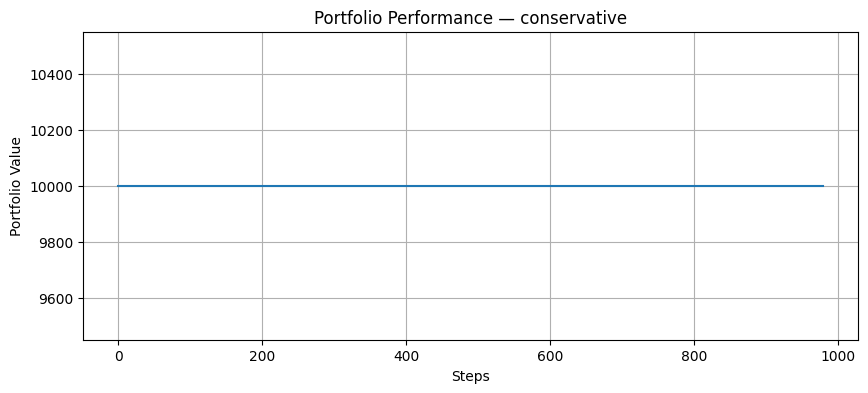

💰 Final Portfolio Value for conservative: 10000.0

🚀 Training Agent: aggressive


Training Progress:   0%|          | 0/500000 [00:00<?, ?it/s]

✅ Training completed for aggressive in 1233.51 seconds
📈 Evaluating agent performance...


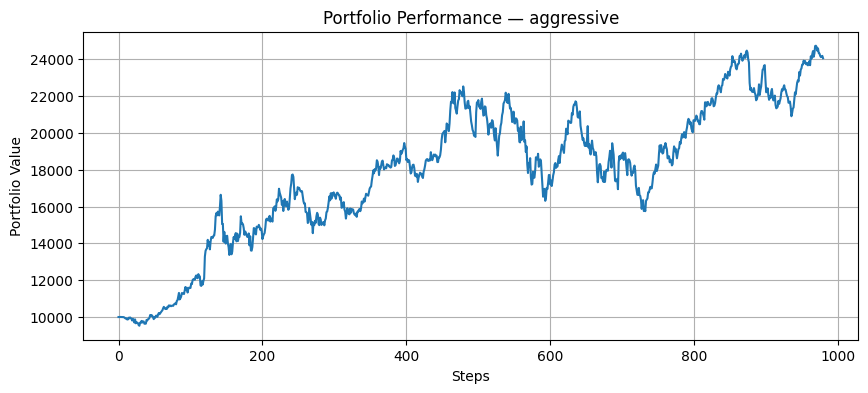

💰 Final Portfolio Value for aggressive: 24051.94508743286

🚀 Training Agent: momentum


Training Progress:   0%|          | 0/500000 [00:00<?, ?it/s]

✅ Training completed for momentum in 1235.06 seconds
📈 Evaluating agent performance...


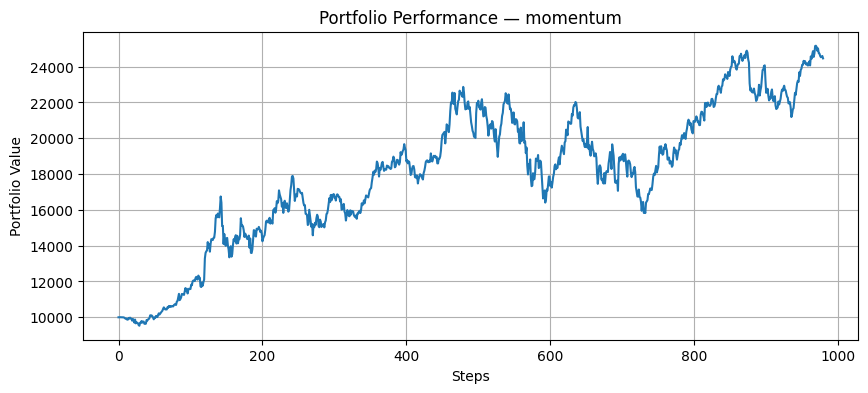

💰 Final Portfolio Value for momentum: 24464.05096054077

🚀 Training Agent: mean_reversion


Training Progress:   0%|          | 0/500000 [00:00<?, ?it/s]

✅ Training completed for mean_reversion in 1245.42 seconds
📈 Evaluating agent performance...


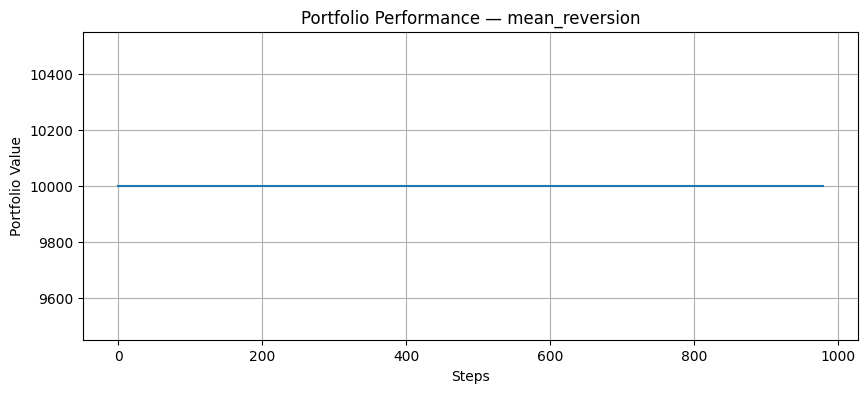

💰 Final Portfolio Value for mean_reversion: 10000.0


In [27]:
# --- ADVANCED TRAINING LOOP FOR ALL 4 AGENTS ---
from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import BaseCallback
from tqdm.auto import tqdm
import os
import time
import matplotlib.pyplot as plt

# Make tensorboard directory
os.makedirs("tb_logs", exist_ok=True)


# --- Callback to show progress bar for training ---
class TQDMCallback(BaseCallback):
    def __init__(self, total_timesteps):
        super().__init__()
        self.progress = tqdm(total=total_timesteps, desc="Training Progress")

    def _on_step(self) -> bool:
        self.progress.update(1)
        return True

    def _on_training_end(self) -> None:
        self.progress.close()


# --- Function: Evaluate trained agent automatically ---
def evaluate_agent(model, agent_name, df):
    env = SingleAgentWrapper(df, agent_name)
    obs, _ = env.reset()
    done = False

    portfolio_values = []
    step = 0

    while not done:
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

        # Track portfolio performance
        price = df.iloc[env.env.current_step]["Close"]
        port = env.env.portfolio[agent_name]
        value = port["balance"] + port["holdings"] * price
        portfolio_values.append(value)

        step += 1

    # Plot
    plt.figure(figsize=(10, 4))
    plt.plot(portfolio_values)
    plt.title(f"Portfolio Performance — {agent_name}")
    plt.xlabel("Steps")
    plt.ylabel("Portfolio Value")
    plt.grid(True)
    plt.show()

    return portfolio_values[-1]


# --- TRAIN ALL 4 AGENTS AUTOMATICALLY ---
agents = ["conservative", "aggressive", "momentum", "mean_reversion"]

TOTAL_TIMESTEPS = 500_000
results = {}

for agent in agents:
    print("\n=====================================")
    print(f"🚀 Training Agent: {agent}")
    print("=====================================")

    env = SingleAgentWrapper(data, agent)

    model = PPO(
        policy="MlpPolicy",
        env=env,
        verbose=0,                       # hide SB3 logs; tqdm will show progress
        learning_rate=3e-4,
        n_steps=2048,
        batch_size=64,
        tensorboard_log=f"tb_logs/{agent}"
    )

    callback = TQDMCallback(total_timesteps=TOTAL_TIMESTEPS)

    start = time.time()
    model.learn(total_timesteps=TOTAL_TIMESTEPS, callback=callback)
    end = time.time()

    model.save(f"{agent}_ppo_model")

    print(f"✅ Training completed for {agent} in {round(end - start, 2)} seconds")
    print("📈 Evaluating agent performance...")

    final_value = evaluate_agent(model, agent, data)
    results[agent] = final_value

    print(f"💰 Final Portfolio Value for {agent}: {final_value}")


In [24]:
# --- STEP 7: EVALUATE TRAINED AGENT ---
from stable_baselines3.common.vec_env import DummyVecEnv

# Reload model
model = PPO.load(f"{agent_name}_ppo_model")

# Create real environment (not vectorized)
eval_env = StockTradingEnv(data)
obs, info = eval_env.reset()

portfolio_values = []
done_agents = set()

while eval_env.agents:
    current_agent = agent_name

    # Get observation for this agent
    if current_agent not in obs:
        break

    action, _ = model.predict(obs[current_agent], deterministic=True)

    # Step env (only this agent acts)
    next_obs, rewards, terms, truncs, infos = eval_env.step({current_agent: action})

    obs = next_obs

    # Track portfolio value
    step_price = data.iloc[eval_env.current_step]["Close"]
    port = eval_env.portfolio[current_agent]
    value = port["balance"] + (port["holdings"] * step_price)
    portfolio_values.append(value)

print("Evaluation completed.")
print("Final Portfolio Value:", portfolio_values[-1])


Evaluation completed.
Final Portfolio Value: 10000.0


Evaluating conservative...
Evaluating aggressive...
Evaluating momentum...
Evaluating mean_reversion...


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


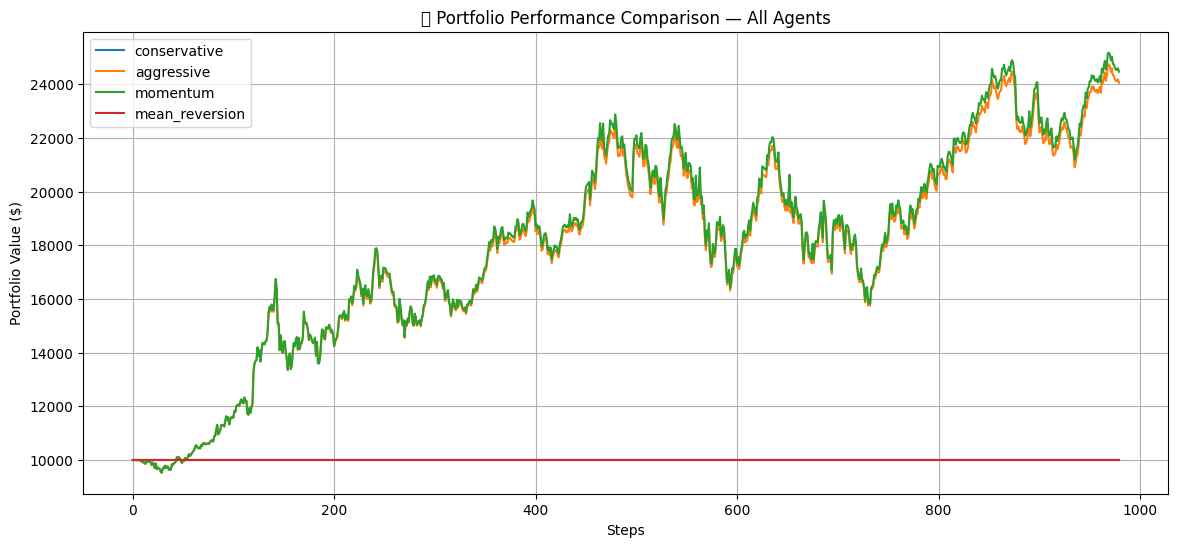

💰 conservative: Final Value = 10000.0
💰 aggressive: Final Value = 24051.94508743286
💰 momentum: Final Value = 24464.05096054077
💰 mean_reversion: Final Value = 10000.0


In [28]:
import matplotlib.pyplot as plt
from stable_baselines3 import PPO

def evaluate_agent_curve(model, agent_name, df):
    env = SingleAgentWrapper(df, agent_name)
    obs, _ = env.reset()
    done = False

    values = []

    while not done:
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

        price = df.iloc[env.env.current_step]["Close"]
        port = env.env.portfolio[agent_name]
        value = port["balance"] + port["holdings"] * price
        values.append(value)

    return values


# --- COMPARE ALL AGENTS ---
agents = ["conservative", "aggressive", "momentum", "mean_reversion"]
model_paths = {
    agent: f"{agent}_ppo_model"
    for agent in agents
}

plt.figure(figsize=(14, 6))

performance = {}

for agent in agents:
    print(f"Evaluating {agent}...")

    # Load trained model
    model = PPO.load(model_paths[agent])

    # Get performance curve
    curve = evaluate_agent_curve(model, agent, data)
    performance[agent] = curve

    # Plot curve
    plt.plot(curve, label=agent)

plt.title("📈 Portfolio Performance Comparison — All Agents")
plt.xlabel("Steps")
plt.ylabel("Portfolio Value ($)")
plt.grid(True)
plt.legend()
plt.show()

# Print final portfolio values
for agent in agents:
    print(f"💰 {agent}: Final Value = {performance[agent][-1]}")


In [29]:
from stable_baselines3 import PPO

battle_models = {
    "conservative": PPO.load("conservative_ppo_model"),
    "aggressive": PPO.load("aggressive_ppo_model"),
    "momentum": PPO.load("momentum_ppo_model"),
    "mean_reversion": PPO.load("mean_reversion_ppo_model")
}


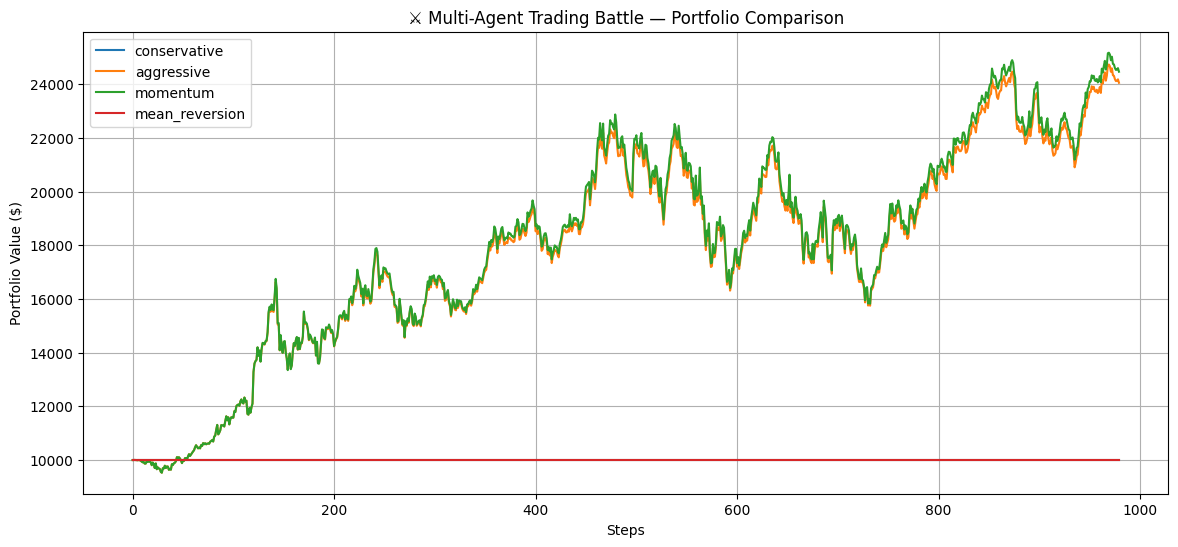

🏁 FINAL RESULTS

conservative: $10000.0
aggressive: $24051.95
momentum: $24464.05
mean_reversion: $10000.0

🥇 Winner: momentum with $24464.05!


In [30]:
import matplotlib.pyplot as plt

def multi_agent_battle(df):
    env = StockTradingEnv(df)
    obs, infos = env.reset()

    # Track value history
    history = {agent: [] for agent in env.agents}

    while env.agents:
        actions = {}

        # Each agent selects action based on its PPO model
        for agent in env.agents:
            model = battle_models[agent]
            action, _ = model.predict(obs[agent], deterministic=True)
            actions[agent] = action

        # Step environment
        obs, rewards, terms, truncs, infos = env.step(actions)

        # Track portfolio values
        if env.current_step < len(df):
            price = df.iloc[env.current_step]["Close"]

            for agent in history:
                port = env.portfolio[agent]
                value = port["balance"] + port["holdings"] * price
                history[agent].append(value)

    return history
battle_history = multi_agent_battle(data)
plt.figure(figsize=(14,6))

for agent, curve in battle_history.items():
    plt.plot(curve, label=agent)

plt.title("⚔️ Multi-Agent Trading Battle — Portfolio Comparison")
plt.xlabel("Steps")
plt.ylabel("Portfolio Value ($)")
plt.grid(True)
plt.legend()
plt.show()
final_scores = {agent: values[-1] for agent, values in battle_history.items()}

print("🏁 FINAL RESULTS\n")
for agent, score in final_scores.items():
    print(f"{agent}: ${round(score, 2)}")

winner = max(final_scores, key=final_scores.get)
print(f"\n🥇 Winner: {winner} with ${round(final_scores[winner], 2)}!")


In [31]:
import numpy as np
import pandas as pd

def calculate_sharpe_ratio(returns, risk_free_rate=0.0):
    returns = np.array(returns)
    if returns.std() == 0:
        return 0
    sharpe = (returns.mean() - risk_free_rate) / returns.std()
    return sharpe

def max_drawdown(portfolio_values):
    portfolio = np.array(portfolio_values)
    peaks = np.maximum.accumulate(portfolio)
    drawdowns = (portfolio - peaks) / peaks
    return drawdowns.min()

def calculate_volatility(returns):
    return np.std(returns)

def win_rate(rewards):
    rewards = np.array(rewards)
    wins = np.sum(rewards > 0)
    return wins / len(rewards) if len(rewards) > 0 else 0


In [32]:
def evaluate_agent_detailed(model, agent_name, df):
    env = SingleAgentWrapper(df, agent_name)
    obs, _ = env.reset()

    done = False
    step = 0

    portfolio_values = []
    rewards_list = []
    buy_points = []
    sell_points = []

    while not done:
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, terminated, truncated, _ = env.step(action)

        done = terminated or truncated
        rewards_list.append(reward)

        # Portfolio value calculation
        price = df.iloc[env.env.current_step]["Close"]
        port = env.env.portfolio[agent_name]
        value = port["balance"] + port["holdings"] * price
        portfolio_values.append(value)

        # Save buy/sell points
        if action == 1:   # Buy
            buy_points.append((env.env.current_step, price))
        elif action == 2: # Sell
            sell_points.append((env.env.current_step, price))

        step += 1

    # Performance metrics
    returns = np.diff(portfolio_values)

    metrics = {
        "Final Value": portfolio_values[-1],
        "Sharpe Ratio": calculate_sharpe_ratio(returns),
        "Max Drawdown": max_drawdown(portfolio_values),
        "Volatility": calculate_volatility(returns),
        "Win Rate": win_rate(rewards_list)
    }

    return portfolio_values, metrics, buy_points, sell_points
